In [1]:
"""Adapted from:
    @longcw faster_rcnn_pytorch: https://github.com/longcw/faster_rcnn_pytorch
    @rbgirshick py-faster-rcnn https://github.com/rbgirshick/py-faster-rcnn
    Licensed under The MIT License [see LICENSE for details]
"""

from __future__ import print_function
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from layers import *
from data import VOC_ROOT, VOCAnnotationTransform, VOCDetection, BaseTransform
from data import VOC_CLASSES as labelmap
from data import voc
import torch.utils.data as data

from ssd_mobilenet import build_ssd_mobilenet

import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2

if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

In [2]:
def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

In [3]:
# ssd_mobv2\weights\ssd300_VOC_200000__20210427-235039.pth
# ssd_mobv2\weights\ssd300_VOC_40000__20210427-053418.pth
args_trained_model = r"C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\weights\ssd300_VOC_40000__20210427-053418.pth"
# C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\weights\
args_save_folder = 'eval/'
args_confidence_threshold = 0.01
args_top_k = 5
args_cuda = True
args_voc_root = VOC_ROOT
args_cleanup = True
args_backbone = 'mobilenet'
args_dataset = 'eval'

In [4]:
if not os.path.exists(args_save_folder):
    os.mkdir(args_save_folder)

if torch.cuda.is_available():
    if args_cuda:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if not args_cuda:
        print("WARNING: It looks like you have a CUDA device, but aren't using \
              CUDA.  Run with --cuda for optimal eval speed.")
        torch.set_default_tensor_type('torch.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [5]:
annopath = os.path.join(args_voc_root, 'VOC2007', 'Annotations', '%s.xml')
imgpath = os.path.join(args_voc_root, 'VOC2007', 'JPEGImages', '%s.jpg')
# imgsetpath = os.path.join(args_voc_root, 'VOC2007', 'ImageSets', 'Main', '{:s}.txt')
imgsetpath = r'C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\data\VOCdevkit\VOC2007\ImageSets\Main\{:s}.txt'
YEAR = '2007'
devkit_path = args_voc_root + 'VOC' + YEAR
dataset_mean = (104, 117, 123)
set_type = 'bird_test'

In [6]:
args_voc_root

'C:/Users/Anubhav/Jupyter Projects/computer_vision [mypytorch]/ssd_mobv2/data/VOCdevkit/'

In [7]:
class Timer(object):
    """A simple timer."""
    def __init__(self):
        self.total_time = 0.
        self.calls = 0
        self.start_time = 0.
        self.diff = 0.
        self.average_time = 0.

    def tic(self):
        # using time.time instead of time.clock because time time.clock
        # does not normalize for multithreading
        self.start_time = time.time()

    def toc(self, average=True):
        self.diff = time.time() - self.start_time
        self.total_time += self.diff
        self.calls += 1
        self.average_time = self.total_time / self.calls
        if average:
            return self.average_time
        else:
            return self.diff

In [8]:
def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        obj_struct['truncated'] = int(obj.find('truncated').text)
        obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text) - 1,
                              int(bbox.find('ymin').text) - 1,
                              int(bbox.find('xmax').text) - 1,
                              int(bbox.find('ymax').text) - 1]
        objects.append(obj_struct)

    return objects


def get_output_dir(name, phase):
    """Return the directory where experimental artifacts are placed.
    If the directory does not exist, it is created.
    A canonical path is built using the name from an imdb and a network
    (if not None).
    """
    filedir = os.path.join(name, phase)
    if not os.path.exists(filedir):
        os.makedirs(filedir)
    return filedir


def get_voc_results_file_template(image_set, cls):
    # VOCdevkit/VOC2007/results/det_test_aeroplane.txt
    filename = 'det_' + image_set + '_%s.txt' % (cls)
    filedir = os.path.join(devkit_path, 'results')
    if not os.path.exists(filedir):
        os.makedirs(filedir)
    path = os.path.join(filedir, filename)
    return path


def write_voc_results_file(all_boxes, dataset):
    for cls_ind, cls in enumerate(labelmap):
        print('Writing {:s} VOC results file'.format(cls))
        filename = get_voc_results_file_template(set_type, cls)
        with open(filename, 'wt') as f:
            for im_ind, index in enumerate(dataset.ids):
                dets = all_boxes[cls_ind+1][im_ind]
                if dets == []:
                    continue
                # the VOCdevkit expects 1-based indices
                for k in range(dets.shape[0]):
                    f.write('{:s} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.
                            format(index[1], dets[k, -1],
                                   dets[k, 0] + 1, dets[k, 1] + 1,
                                   dets[k, 2] + 1, dets[k, 3] + 1))


def do_python_eval(output_dir='output', use_07=True):
    cachedir = os.path.join(devkit_path, 'annotations_cache')
    aps = []
    # The PASCAL VOC metric changed in 2010
    use_07_metric = use_07
    print('VOC07 metric? ' + ('Yes' if use_07_metric else 'No'))
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    for i, cls in enumerate(labelmap):
        filename = get_voc_results_file_template(set_type, cls)
        rec, prec, ap = voc_eval(
           filename, annopath, imgsetpath.format(set_type), cls, cachedir,
           ovthresh=0.5, use_07_metric=use_07_metric)
        aps += [ap]
        print('AP for {} = {:.4f}'.format(cls, ap))
        with open(os.path.join(output_dir, cls + '_pr.pkl'), 'wb') as f:
            pickle.dump({'rec': rec, 'prec': prec, 'ap': ap}, f)
    print('Mean AP = {:.4f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('Results:')
    for ap in aps:
        print('{:.3f}'.format(ap))
    print('{:.3f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('')
    print('--------------------------------------------------------------')
    print('Results computed with the **unofficial** Python eval code.')
    print('Results should be very close to the official MATLAB eval code.')
    print('--------------------------------------------------------------')


def voc_ap(rec, prec, use_07_metric=True):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:True).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def voc_eval(detpath,
             annopath,
             imagesetfile,
             classname,
             cachedir,
             ovthresh=0.5,
             use_07_metric=True):
    """rec, prec, ap = voc_eval(detpath,
                           annopath,
                           imagesetfile,
                           classname,
                           [ovthresh],
                           [use_07_metric])
Top level function that does the PASCAL VOC evaluation.
detpath: Path to detections
   detpath.format(classname) should produce the detection results file.
annopath: Path to annotations
   annopath.format(imagename) should be the xml annotations file.
imagesetfile: Text file containing the list of images, one image per line.
classname: Category name (duh)
cachedir: Directory for caching the annotations
[ovthresh]: Overlap threshold (default = 0.5)
[use_07_metric]: Whether to use VOC07's 11 point AP computation
   (default True)
"""
# assumes detections are in detpath.format(classname)
# assumes annotations are in annopath.format(imagename)
# assumes imagesetfile is a text file with each line an image name
# cachedir caches the annotations in a pickle file
# first load gt
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile = os.path.join(cachedir, 'annots.pkl')
    # read list of images
    with open(imagesetfile, 'r') as f:
        lines = f.readlines()
    imagenames = [x.strip().split()[0] for x in lines]
    if not os.path.isfile(cachefile):
        # load annots
        recs = {}
        for i, imagename in enumerate(imagenames):
            recs[imagename] = parse_rec(annopath % (imagename))
            if i % 100 == 0:
                print('Reading annotation for {:d}/{:d}'.format(
                   i + 1, len(imagenames)))
        # save
        print('Saving cached annotations to {:s}'.format(cachefile))
        with open(cachefile, 'wb') as f:
            pickle.dump(recs, f)
    else:
        # load
        with open(cachefile, 'rb') as f:
            recs = pickle.load(f)

    # extract gt objects for this class
    class_recs = {}
    npos = 0
    for imagename in imagenames:
        R = [obj for obj in recs[imagename] if obj['name'] == classname]
        bbox = np.array([x['bbox'] for x in R])
        difficult = np.array([x['difficult'] for x in R]).astype(np.bool)
        det = [False] * len(R)
        npos = npos + sum(~difficult)
        class_recs[imagename] = {'bbox': bbox,
                                 'difficult': difficult,
                                 'det': det}

    # read dets
    detfile = detpath.format(classname)
    with open(detfile, 'r') as f:
        lines = f.readlines()
    if any(lines) == 1:

        splitlines = [x.strip().split(' ') for x in lines]
        image_ids = [x[0] for x in splitlines]
        confidence = np.array([float(x[1]) for x in splitlines])
        BB = np.array([[float(z) for z in x[2:]] for x in splitlines])

        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d in range(nd):
            R = class_recs[image_ids[d]]
            bb = BB[d, :].astype(float)
            ovmax = -np.inf
            BBGT = R['bbox'].astype(float)
            if BBGT.size > 0:
                # compute overlaps
                # intersection
                ixmin = np.maximum(BBGT[:, 0], bb[0])
                iymin = np.maximum(BBGT[:, 1], bb[1])
                ixmax = np.minimum(BBGT[:, 2], bb[2])
                iymax = np.minimum(BBGT[:, 3], bb[3])
                iw = np.maximum(ixmax - ixmin, 0.)
                ih = np.maximum(iymax - iymin, 0.)
                inters = iw * ih
                uni = ((bb[2] - bb[0]) * (bb[3] - bb[1]) +
                       (BBGT[:, 2] - BBGT[:, 0]) *
                       (BBGT[:, 3] - BBGT[:, 1]) - inters)
                overlaps = inters / uni
                ovmax = np.max(overlaps)
                jmax = np.argmax(overlaps)

            if ovmax > ovthresh:
                if not R['difficult'][jmax]:
                    if not R['det'][jmax]:
                        tp[d] = 1.
                        R['det'][jmax] = 1
                    else:
                        fp[d] = 1.
            else:
                fp[d] = 1.

        # compute precision recall
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp / float(npos)
        # avoid divide by zero in case the first detection matches a difficult
        # ground truth
        prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
        ap = voc_ap(rec, prec, use_07_metric)
    else:
        rec = -1.
        prec = -1.
        ap = -1.

    return rec, prec, ap


def test_net(save_folder, net, cuda, dataset, transform, top_k,
             im_size=300, thresh=0.05):
    num_images = len(dataset)
    # all detections are collected into:
    #    all_boxes[cls][image] = N x 5 array of detections in
    #    (x1, y1, x2, y2, score)
    all_boxes = [[[] for _ in range(num_images)]
                 for _ in range(len(labelmap)+1)]

    # timers
    _t = {'im_detect': Timer(), 'misc': Timer()}
    output_dir = get_output_dir('ssd300_120000', set_type)
    det_file = os.path.join(output_dir, 'detections.pkl')

    for i in range(num_images):
        im, gt, h, w = dataset.pull_item(i)

        x = Variable(im.unsqueeze(0))
        if args_cuda:
            x = x.cuda()
        _t['im_detect'].tic()
        result = net(x)

        softmax = torch.nn.Softmax(dim=-1)
        loc = result[0]
        conf = result[1]
        priors = result[2]
        detections = Detect.apply(2, 0, 200, 0.01, 0.45, loc, softmax(conf), priors).data     
        # detections = detect(loc, softmax(conf), priors)
        detect_time = _t['im_detect'].toc(average=False)

        # skip j = 0, because it's the background class
        for j in range(1, detections.size(1)):
            dets = detections[0, j, :]
            mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()
            dets = torch.masked_select(dets, mask).view(-1, 5)
            if dets.size(0) == 0:
                continue
            boxes = dets[:, 1:]
            boxes[:, 0] *= w
            boxes[:, 2] *= w
            boxes[:, 1] *= h
            boxes[:, 3] *= h
            scores = dets[:, 0].cpu().numpy()
            cls_dets = np.hstack((boxes.cpu().numpy(),
                                  scores[:, np.newaxis])).astype(np.float32,
                                                                 copy=False)
            all_boxes[j][i] = cls_dets

        print('im_detect: {:d}/{:d} {:.3f}s'.format(i + 1,
                                                    num_images, detect_time))

    with open(det_file, 'wb') as f:
        pickle.dump(all_boxes, f, pickle.HIGHEST_PROTOCOL)

    print('Evaluating detections')
    evaluate_detections(all_boxes, output_dir, dataset)


def evaluate_detections(box_list, output_dir, dataset):
    write_voc_results_file(box_list, dataset)
    do_python_eval(output_dir)

In [9]:
# load net
num_classes = len(labelmap) + 1                      # +1 for background
net = build_ssd_mobilenet('test', voc)
net = torch.load(args_trained_model)
net.eval()
print('Finished loading model!')

# load data
dataset = VOCDetection(args_voc_root, [('2007', set_type)],
                        BaseTransform(300, dataset_mean),
                        VOCAnnotationTransform())
if args_cuda:
    net = net.cuda()
    cudnn.benchmark = True
# evaluation
test_net(args_save_folder, net, args_cuda, dataset,
            BaseTransform(300, dataset_mean), args_top_k, 300,
            thresh=args_confidence_threshold)

c:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\ssd_mobilenet.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
Finished loading model!
C:\Users\Anubhav\anaconda3\envs\mypytorch\lib\site-packages\torch\nn\functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
im_detect: 1/282 2.104s
im_detect: 2/282 0.046s
im_detect: 3/282 0.047s
im_detect: 4/282 0.041s
im_detect: 5/282 0.031s
im_detect: 6/282 0.031s
im_detect: 7/282 0.041s
im_detect: 8/282 0.063s
im_detect: 9/282 0.059s
im_detect: 10/282 0.038s
im_detect: 11/282 0.042s
im_detect: 12/282 0.043s
im_detect: 13/282 0.035s
im_detect: 14/282 0.028s
im_detect: 15/282 0.034s
im_detect: 16/282 0.034s
im_detect: 17/282 0.033s
im_detect: 18/282 0.043s
im_detec

In [11]:
args_save_folder

'eval/'

In [16]:
with open(r'C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\ssd300_120000\bird_test\detections.pkl', 'rb') as f:
    all_bx = pickle.load(f)

In [20]:
with open(r'C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\ssd300_120000\bird_test\birdSE_pr.pkl', 'rb') as f:
    iden = pickle.load(f)

In [21]:
iden

{'rec': array([0.00217865, 0.0043573 , 0.00653595, ..., 0.74727669, 0.74727669,
        0.74727669]),
 'prec': array([1.        , 1.        , 1.        , ..., 0.04118141, 0.04117647,
        0.04117153]),
 'ap': 0.5652249235228903}

In [29]:
len(all_bx[1][1][0])

5

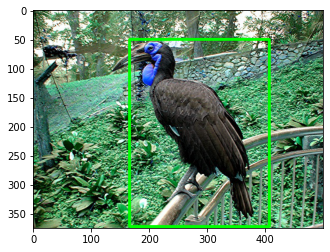

In [7]:
import cv2
img = r'C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\data\VOCdevkit\VOC2007\JPEGImages\000057.jpg'

image = cv2.imread(img)
gg = cv2.rectangle(image, (166, 50), (407, 372), (0,255,0), 3)
plt.imshow(gg)

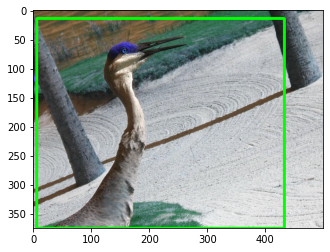

In [8]:
import cv2
img = r'C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\data\VOCdevkit\VOC2007\JPEGImages\000068.jpg'

image = cv2.imread(img)
gg = cv2.rectangle(image, (6, 14), (433, 375), (0,255,0), 3)
plt.imshow(gg)

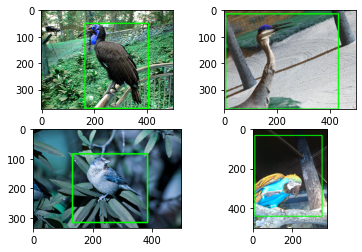

In [23]:
import cv2
img1 = r'C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\data\VOCdevkit\VOC2007\JPEGImages\000057.jpg'
img2 = r'C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\data\VOCdevkit\VOC2007\JPEGImages\000068.jpg'
img3 = r'C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\data\VOCdevkit\VOC2007\JPEGImages\000106.jpg'
img4 = r'C:\Users\Anubhav\Jupyter Projects\computer_vision [mypytorch]\ssd_mobv2\data\VOCdevkit\VOC2007\JPEGImages\000115.jpg'
image1 = cv2.imread(img1)
image2 = cv2.imread(img2)
image3 = cv2.imread(img3)
image4 = cv2.imread(img4)

plt.subplot(2, 2, 1)
gg1 = cv2.rectangle(image1, (166, 50), (407, 372), (0,255,0), 3)
plt.imshow(gg1)

plt.subplot(2, 2, 2)
gg2 = cv2.rectangle(image2, (6, 14), (433, 375), (0,255,0), 3)
plt.imshow(gg2)

plt.subplot(2, 2, 3)
gg3 = cv2.rectangle(image3, (132, 83), (384, 314), (0,255,0), 3)
plt.imshow(gg3)

plt.subplot(2, 2, 4) # 9.4 32.0 344.6 439.8
gg4 = cv2.rectangle(image4, (9, 32), (345, 440), (0,255,0), 3)
plt.imshow(gg4)

plt.savefig('bird_images.pdf')
# plt.subplot(1, 2, 2)
# plt.imshow(image2)